<a href="https://colab.research.google.com/github/harperd/machine-learning/blob/master/notebooks/binary-logistic-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Logistic Regression

Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams.

In [0]:
# NumPy adds support for large, multi-dimensional arrays and matrices, along with a large collection 
# of high-level mathematical functions to operate on these arrays.
import numpy as np

# Matplotlib is a plotting library for the Python programming language and its numerical mathematics 
# extension NumPy. It provides an object-oriented API for embedding plots into applications using 
# general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK+.
import matplotlib.pyplot as plt

# Allow saving our graphs in the notebook
%matplotlib inline

# Pandas is a software library for data manipulation and analysis. In particular, it offers data 
# structures and operations for manipulating numerical tables and time series.
import pandas as pd

# SciPy optimize provides functions for minimizing (or maximizing) objective 
# functions, possibly subject to constraints. It includes solvers for nonlinear 
# problems (with support for both local and global optimization algorithms), 
# linear programing, constrained and nonlinear least-squares, root finding
# and curve fitting.
import scipy.optimize as opt

## Chart Dark Theme For Google Colab Dark Mode

In [0]:
# import matplotlib.style as style
# style.use('dark_background')

## Read Sample Data

In [3]:
df_raw = pd.read_csv(
    'https://raw.githubusercontent.com/harperd/machine-learning/master/data/ex2data1.csv',
    header = None,
    names = ['Exam 1', 'Exam 2', 'Admitted'])
%time print(f'{len(df_raw.index):,} rows read.')

100 rows read.
CPU times: user 154 µs, sys: 0 ns, total: 154 µs
Wall time: 160 µs


In [4]:
df_raw.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


## Plot The Sample Data

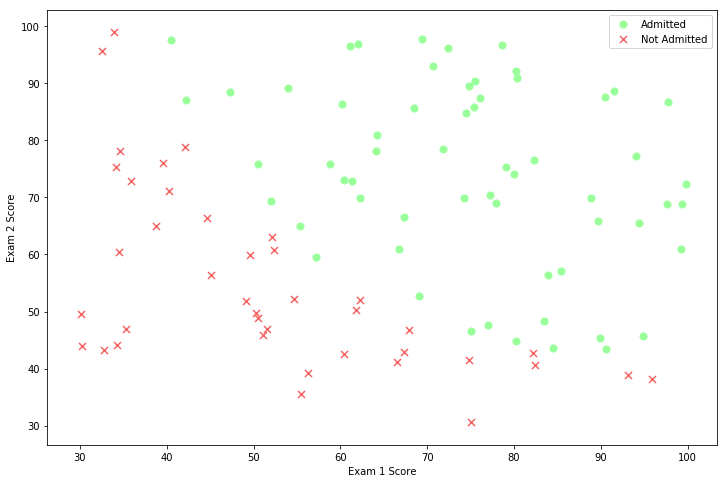

In [5]:
def plot_data(plt_data):
  data = plt_data['data']
  classification = plt_data['classification']
  
  df = data['data_frame']
  classifier = classification['classifier_col']
  pos_label = classification['pos_label']
  neg_label = classification['neg_label']
  feature1 = data['feature1_col']
  feature2 = data['feature2_col']
  x_label = data['feature1_label']
  y_label = data['feature2_label']
  
  # Get values for positive and negative.
  # We will plot these separately.
  positive = df[df[classifier].isin([1])]
  negative = df[df[classifier].isin([0])]

  fig, ax = plt.subplots(figsize = ( 12, 8 ))
  
  ax.scatter(positive[feature1], positive[feature2], s=50, c='#99FF99', marker='o', label=pos_label)
  ax.scatter(negative[feature1], negative[feature2], s=50, c='#F66666', marker='x', label=neg_label)
  
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  
  ax.legend()

  #set_theme(ax)
  
  return ax

plt_data = {
  'data': {
      'data_frame'    : df_raw,
      'feature1_col'  : 'Exam 1',
      'feature1_label': 'Exam 1 Score',
      'feature2_col'  : 'Exam 2',
      'feature2_label': 'Exam 2 Score'
  },
  'classification': {
      'classifier_col': 'Admitted',
      'pos_label'     : 'Admitted',
      'neg_label'     : 'Not Admitted'
  }
}

ax = plot_data(plt_data)

## Get X, y and Initial Theta Values

In [6]:
df_alt = df_raw.copy()

# add a ones column - this makes the matrix multiplication work out easier
df_alt.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
#cols = data.shape[1]
X = df_alt.iloc[:, 0:3]
y = df_alt.iloc[:, 3:4]

# Note: It is no longer recommended to use np.matrix, even for linear algebra. 
# Instead use regular arrays. The class may be removed in the future.
X = np.array(X.values) # 2D array
y = np.array(y.values) # 2D array
theta = np.array(np.zeros(3), ndmin = 2) # 2D array

X.shape, theta.shape, y.shape

((100, 3), (1, 3), (100, 1))

## Create Functions

### Create The SIgmoid Function


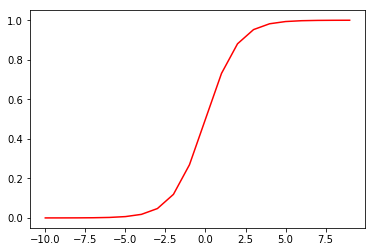

In [7]:
def sigmoid(z):
  return 1 / ( 1 + np.exp(-z) )

nums = np.arange(-10, 10, step = 1)

fig, ax = plt.subplots()
ax.plot(nums, sigmoid(nums), 'r')

plt.show()

### Create a Function for Computing a Hypothesis

In [0]:
def compute_hypothesis(theta, X):
  # Compute our hypothesis
  z = X @ theta.T

  # Scale our hypothesis using Sigmoid
  # Here, if the parameter is zero then the sigmoid value will be 0.5.
  h = sigmoid(z)
  
  return h

### Create a Function for Computing Cost

In [9]:
def compute_cost(theta, X, y):
  theta = np.array(theta, ndmin = 2)
  X = np.array(X, ndmin = 2)
  y = np.array(y, ndmin = 2)

  # Compute our hypothesis
  h = compute_hypothesis(theta, X)
    
  first = np.log(h) * -y
  second = np.log(1 - h) * (1 - y)

  # The number of examples
  m = len(y)
  
  return np.sum(first - second) / m

cost = compute_cost(theta, X, y)
print(f'Cost = {cost}')

Cost = 0.6931471805599453


### Create Function for Computing a Single Gradient

In [10]:
def compute_gradient(theta, X, y):
  theta = np.array(theta, ndmin = 2)
  X = np.array(X, ndmin = 2)
  y = np.array(y, ndmin = 2)
  
  # Compute our hypothesis
  h = compute_hypothesis(theta, X)
    
  # Get the error
  error = h - y

  # The number of examples
  m = len(y)

  # Calculate the gradient
  gradient = (( error.T @ X )) + ((.01 / m) * theta)

  return gradient
  
compute_gradient(theta, X, y)

array([[  -10.        , -1200.92165893, -1126.28422055]])

## Minimize Theta Values

In [11]:
# Minimize a function with variables subject to bounds,
# using gradient information using truncated Newton or Newton Conjugate-Gradient.
result = opt.fmin_tnc(
  # Initial guess.
  x0 = theta,
  # Objective function to be minimized.
  func = compute_cost,
  # Gradient of func.
  fprime = compute_gradient,
  # Extra arguments passed to f and fprime.
  args = ( X, y ))

theta_min = result[0]
iterations = result[1]
cost = compute_cost(theta_min, X, y)

print(f'Minimized theta values: {theta_min}')
print(f'Number of iterations: {iterations}')
print(f'Cost: {cost}')

Minimized theta values: [-25.06609967   0.20543869   0.20073907]
Number of iterations: 100
Cost: 0.20349909926384105


## Calculate Model Accuracy

In [12]:
def make_predictions(theta, X):
  # Compute our hypothesis
  h = compute_hypothesis(theta, X)
  
  # print(h)
  
  # Make prediction of 1 or zero based on threshold.
  predictions = [ 1 if x >= 0.5 else 0 for x in h ]

  return predictions

def compute_accuracy(predictions, y):
  # Get the correct predictions where correct is 1 and
  # incorrect is 0.
  correct = [ 
      1 if p_val - y_val == 0 else 0 
      # The purpose of zip() is to map the similar index of multiple 
      # containers so that they can be used just using as single entity.
      for (p_val, y_val) in zip(predictions, y)
  ]
  
  # Calculate the overall accuracy.
  #
  # The map() function returns a list of the results after applying the given
  # function to each item of a given iterable (list, tuple etc.).
  accuracy = round(( sum(correct) / len(correct)) * 100)
  
  return accuracy

predictions = make_predictions(theta_min, X)
accuracy = compute_accuracy(predictions, y)

print(f'Accuracy: {accuracy}%')

Accuracy: 89%


## Plot the Decision Boundary

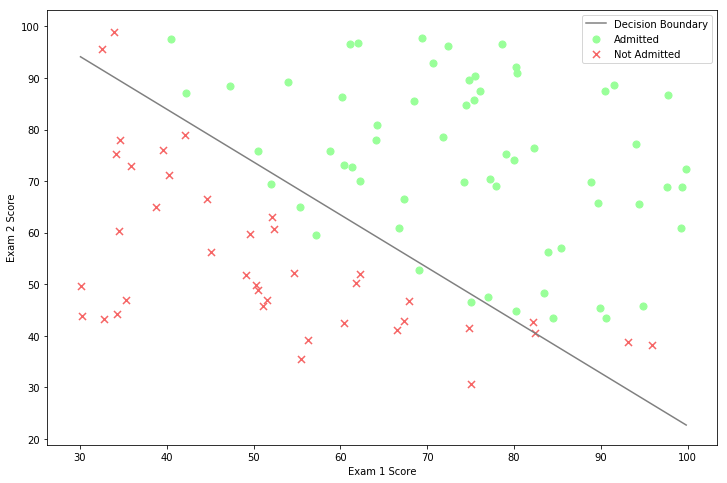

In [13]:
def plot_decision_boundary(theta, plt_data):
  ax = plot_data(plt_data)
  
  data = plt_data['data']
  df = data['data_frame']
  feature1_col = data['feature1_col']
  feature2_col = data['feature2_col']

  # Get x values
  # These are the min and max values that span the
  # x axis.
  data_range = pd.concat([df[feature1_col], df[feature2_col]])
  x = np.linspace(data_range.min(), data_range.max(), df.shape[0])

  # Get y values
  # These are the min and max values that span the
  # y axis.
  y = ( -1 / theta[2] ) * (( theta[1] * x ) + theta[0] )
  
  ax.plot(x, y, 'grey', label = 'Decision Boundary')
  ax.legend()
  
plot_decision_boundary(
  theta_min,
  plt_data
)

## Make a Prediction

In [14]:
def make_prediction(theta, exam1, exam2):
  h = compute_hypothesis(theta, [1, exam1, exam2])

  status = 'Admitted' if h >= 0.5 else 'Not Admitted'

  print(f'Exam 1 Score: {exam1}%')
  print(f'Exam 2 Score: {exam2}%')
  print(f'Admission Status: {status}')
  print('')


make_prediction(theta_min, 85, 90)
make_prediction(theta_min, 60, 50)

Exam 1 Score: 85%
Exam 2 Score: 90%
Admission Status: Admitted

Exam 1 Score: 60%
Exam 2 Score: 50%
Admission Status: Not Admitted

